# Comparing electron id between nominal and super trigger cells



In [185]:
#imports and setup
%matplotlib inline
%cd /home/naodell/work/hgcal/analysis

import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import plotly.plotly as plotly
import plotly.graph_objs as go
from plotly.graph_objs import Surface, Mesh3d
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
    
from scripts.helpers import eta_to_theta, propagate_to_face, assign_phi, delta_phi

%connect_info

/home/naodell/work/hgcal/analysis


{
  "shell_port": 41453,
  "iopub_port": 55435,
  "stdin_port": 51543,
  "control_port": 42873,
  "hb_port": 45773,
  "ip": "127.0.0.1",
  "key": "1c5bded3-3c84efe99f45186f458eae2b",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-f7f7b122-e52f-473e-8e90-62f032fcc654.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [186]:
# get the nominal data
infile = open('local_data/electron_tc_nominal/output_0.pkl', 'rb')
evts_particles = pickle.load(infile)
evts_cells = pickle.load(infile)
evts_clusters = pickle.load(infile)

# match electrons to clusters
matched_data = []
for ievt, particles in enumerate(evts_particles):
    electron1 = particles.iloc[0]
    electron2 = particles.iloc[1]
    clusters = evts_clusters[ievt].query('cl_pt > 5') # this cut is just to get around matching to a low energy cluster
    
    # match electron 1 to cluster
    deta = np.abs(electron1.eta - clusters.cl_eta)
    dphi = np.abs(electron1.phi - clusters.cl_phi)
    dphi[dphi > np.pi] = 2*np.pi - dphi[dphi > np.pi]
    dr = np.sqrt(deta**2 + dphi**2)
    cluster1 = clusters.loc[dr.idxmin()]
    matched_data.append(pd.concat([electron1, cluster1]))
    
    # match electron 2 to cluster
    deta = np.abs(electron2.eta - clusters.cl_eta)
    dphi = np.abs(electron2.phi - clusters.cl_phi)
    dphi[dphi > np.pi] = 2*np.pi - dphi[dphi > np.pi]
    dr = np.sqrt(deta**2 + dphi**2)
    cluster2 = clusters.loc[dr.idxmin()]
    matched_data.append(pd.concat([electron2, cluster2]))
    
df_matched_nominal = pd.DataFrame(matched_data, index=np.arange(len(matched_data)))

In [187]:
# get the super-tc data
infile = open('local_data/electron_tc_super/output_0.pkl', 'rb')
evts_particles = pickle.load(infile)
evts_cells = pickle.load(infile)
evts_clusters = pickle.load(infile)

# match electrons to clusters
matched_data = []
for ievt, particles in enumerate(evts_particles):
    electron1 = particles.iloc[0]
    electron2 = particles.iloc[1]
    clusters = evts_clusters[ievt].query('cl_pt > 5') # this cut is just to get around matching to a low energy cluster
    
    # match electron 1 to cluster
    deta = np.abs(electron1.eta - clusters.cl_eta)
    dphi = np.abs(electron1.phi - clusters.cl_phi)
    dphi[dphi > np.pi] = 2*np.pi - dphi[dphi > np.pi]
    dr = np.sqrt(deta**2 + dphi**2)
    cluster1 = clusters.loc[dr.idxmin()]
    matched_data.append(pd.concat([electron1, cluster1]))
    
    # match electron 2 to cluster
    deta = np.abs(electron2.eta - clusters.cl_eta)
    dphi = np.abs(electron2.phi - clusters.cl_phi)
    dphi[dphi > np.pi] = 2*np.pi - dphi[dphi > np.pi]
    dr = np.sqrt(deta**2 + dphi**2)
    cluster2 = clusters.loc[dr.idxmin()]
    matched_data.append(pd.concat([electron2, cluster2]))
    
df_matched_super = pd.DataFrame(matched_data, index=np.arange(len(matched_data)))

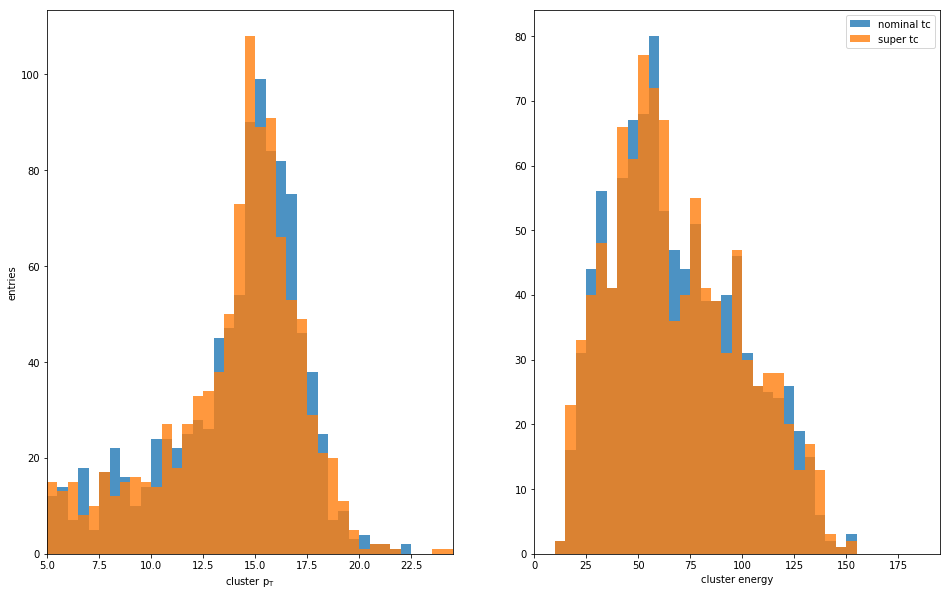

In [199]:
# makes some plots
fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharey=False, facecolor='white')

ax = axes[0]
binning = np.arange(5, 25, 0.5)
ax.hist(df_matched_nominal.cl_pt, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.hist(df_matched_super.cl_pt, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.set_xlabel('cluster $\sf p_{T}$')
ax.set_ylabel('entries')
ax.set_xlim(binning[0], binning[-1])

ax = axes[1]
binning = np.arange(0., 200., 5)
ax.hist(df_matched_nominal.cl_e, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.hist(df_matched_super.cl_e, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.set_xlabel('cluster energy')
ax.set_xlim(binning[0], binning[-1])

ax.legend(['nominal tc', 'super tc'])

plt.savefig('plots/kinematics.png')
plt.show()

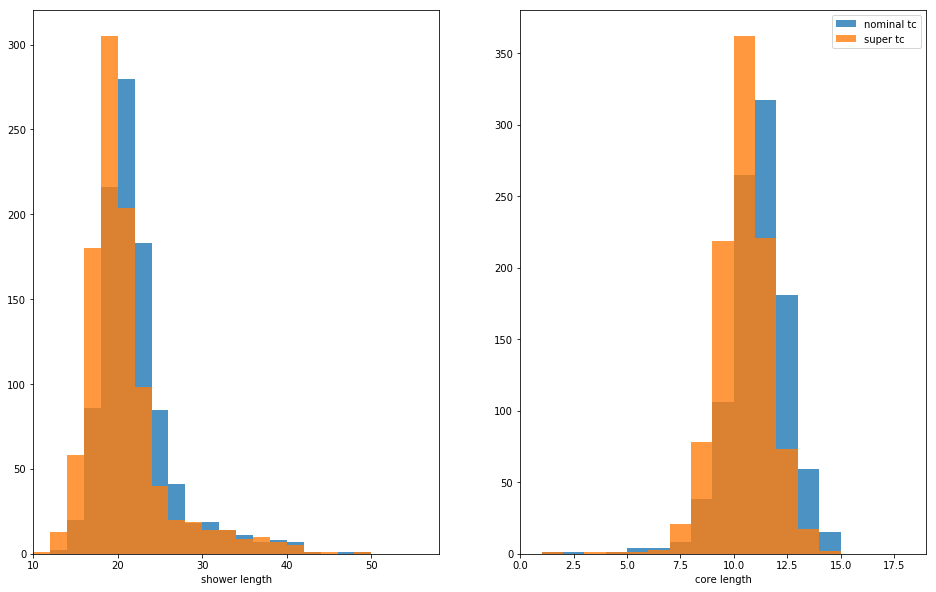

In [201]:
fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharey=False, facecolor='white')

ax = axes[0]
binning = np.arange(10., 60., 2)
ax.hist(df_matched_nominal.showerlength, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.hist(df_matched_super.showerlength, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.set_xlabel('shower length')
ax.set_xlim(binning[0], binning[-1])

ax = axes[1]
binning = np.arange(0., 20., 1)
ax.hist(df_matched_nominal.corelength, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.hist(df_matched_super.corelength, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.set_xlabel('core length')
ax.set_xlim(binning[0], binning[-1])

ax.legend(['nominal tc', 'super tc'])
plt.savefig('plots/shower_length.png')
plt.show()

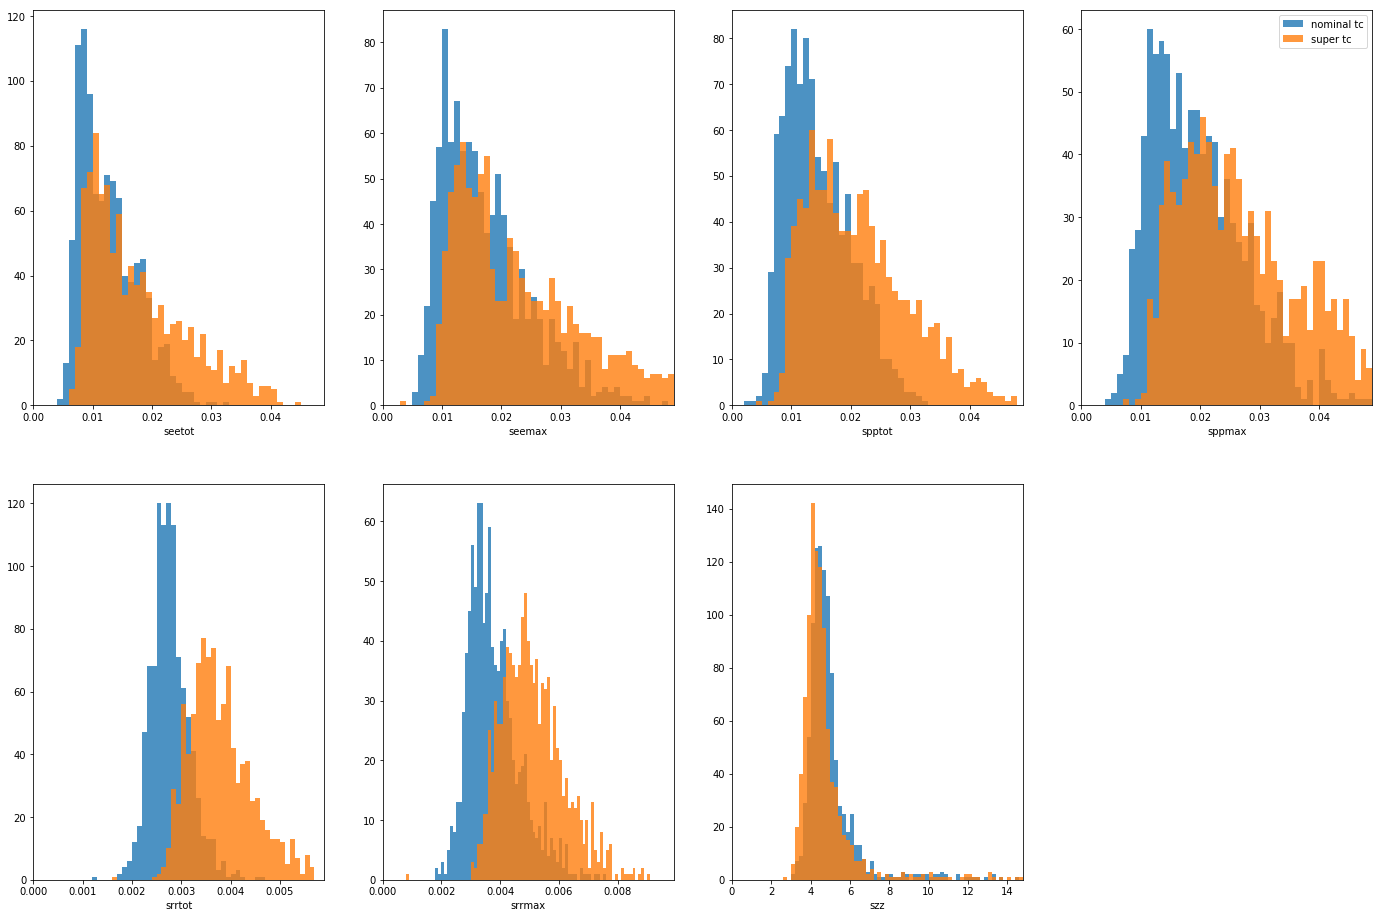

In [202]:
fig, axes = plt.subplots(2, 4, figsize=(24, 16), sharey=False, facecolor='white')

ax = axes[0][0]
binning = np.arange(0., 0.05, 0.001)
ax.hist(df_matched_nominal.seetot, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.hist(df_matched_super.seetot, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.set_xlabel('seetot')
ax.set_xlim(binning[0], binning[-1])

ax = axes[0][1]
binning = np.arange(0., 0.05, 0.001)
ax.hist(df_matched_nominal.seemax, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.hist(df_matched_super.seemax, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.set_xlabel('seemax')
ax.set_xlim(binning[0], binning[-1])

ax = axes[0][2]
binning = np.arange(0., 0.05, 0.001)
ax.hist(df_matched_nominal.spptot, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.hist(df_matched_super.spptot, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.set_xlabel('spptot')
ax.set_xlim(binning[0], binning[-1])

ax = axes[0][3]
binning = np.arange(0., 0.05, 0.001)
ax.hist(df_matched_nominal.sppmax, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.hist(df_matched_super.sppmax, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.set_xlabel('sppmax')
ax.set_xlim(binning[0], binning[-1])

ax.legend(['nominal tc', 'super tc'])

ax = axes[1][0]
binning = np.arange(0., 0.006, 0.0001)
ax.hist(df_matched_nominal.srrtot, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.hist(df_matched_super.srrtot, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.set_xlabel('srrtot')
ax.set_xlim(binning[0], binning[-1])

ax = axes[1][1]
binning = np.arange(0., 0.01, 0.0001)
ax.hist(df_matched_nominal.srrmax, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.hist(df_matched_super.srrmax, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.set_xlabel('srrmax')
ax.set_xlim(binning[0], binning[-1])

ax = axes[1][2]
binning = np.arange(0., 15., 0.2)
ax.hist(df_matched_nominal.szz, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.hist(df_matched_super.szz, bins=binning, histtype='stepfilled', lw=2, alpha=0.8)
ax.set_xlabel('szz')
ax.set_xlim(binning[0], binning[-1])

axes[1][3].axis('off')

plt.savefig('plots/sigma_dist.png')
plt.show()